In [23]:
import os
import torch
import torchaudio
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import Counter
import torch.backends.cudnn as cudnn
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import wandb

cudnn.benchmark = True
plt.ion()   # interactive mode

INPUT_RESOLUTION=128

IMAGE_FOLDER = "..//image_folder_reduced_noise_further"

MEAN = 0.7239
STD = 0.2953

In [2]:
def get_mean_std(loader):
    # Compute the mean and standard deviation of all pixels in the dataset
    num_pixels = 0
    mean = 0.0
    std = 0.0
    for images, _ in loader:
        batch_size, num_channels, height, width = images.shape
        num_pixels += batch_size
        mean += images.mean(axis=(0, 2, 3)).sum() * batch_size
        std += images.std(axis=(0, 2, 3)).sum() * batch_size

    mean /= num_pixels
    std /= num_pixels

    return mean, std

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((INPUT_RESOLUTION,INPUT_RESOLUTION)),
    transforms.ToTensor()])

full_dataset = datasets.ImageFolder(root=IMAGE_FOLDER,transform=transform)

loader = DataLoader(full_dataset, batch_size=32, shuffle=True,num_workers=4, pin_memory=True)
mean, std = get_mean_std(loader)

MEAN = mean
STD = std

print(mean)
print(std) 

tensor(0.8275)
tensor(0.2848)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print("CUDA available:", torch.cuda.is_available())  # Should print True
print("CUDA device count:", torch.cuda.device_count())  # Number of GPUs

cuda
CUDA available: True
CUDA device count: 1


In [3]:
transform = v2.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((INPUT_RESOLUTION,INPUT_RESOLUTION)),
    # transforms.RandomCrop(INPUT_RESOLUTION), # added RandomCrop, no padding
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN,std=STD)])

normalized_train_dataset = datasets.ImageFolder(root=IMAGE_FOLDER,transform=transform)
CLASS_NAMES = normalized_train_dataset.classes

train_set, test_set = train_test_split(normalized_train_dataset, test_size= 0.1, random_state= 42)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

In [4]:
# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(1, 60, 5) # if overfit drop/ one layer + pooling
#         self.bn1 = nn.BatchNorm2d(60) # added batch norm
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(60, 160, 12)
#         self.bn2 = nn.BatchNorm2d(160)
#         conv1_output = (INPUT_RESOLUTION - 4) // 2 + 1  # Conv1 + Pool
#         conv2_output = (conv1_output - 11) // 2 + 1     # Conv2 + Pool

#         # Update fc1 input size based on calculated output size
#         # self.fc1 = nn.Linear(160 * conv2_output * conv2_output, 1200) 100000
#         self.fc1 = nn.Linear(100000, 1200)
#         self.fc2 = nn.Linear(1200, 840)
#         self.fc3 = nn.Linear(840, 12)

#     def forward(self, x):
#         # x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.bn1(self.conv1(x))))
#         # x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.bn2(self.conv2(x))))
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 5, bias = False) # if overfit drop/ one layer + pooling
        self.bn1 = nn.BatchNorm2d(64) # added batch norm
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 96, 3, bias = False)
        self.bn2 = nn.BatchNorm2d(96)
        self.conv3 = nn.Conv2d(96, 128, 3, bias = False)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool_last = nn.MaxPool2d(4, 4)
        conv1_output = (INPUT_RESOLUTION - 4) // 2 + 1  # Conv1 + Pool
        conv2_output = (conv1_output - 11) // 2 + 1     # Conv2 + Pool

        # Update fc1 input size based on calculated output size
        # self.fc1 = nn.Linear(160 * conv2_output * conv2_output, 1200) 100000
        self.fc1 = nn.Linear(6272, 200) #RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x6272 and 2048x200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 12)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool_last(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 6272) # the same as flatten
        # x = x.view(x.size(0), -1)  # Keeps batch size intact
        # x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class VGG_with_BN_dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 3) # if overfit drop/ one layer + pooling
        self.conv2 = nn.Conv2d(64, 64, 3, bias = False)
        self.bn1 = nn.BatchNorm2d(64) # added batch norm
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 96, 3)
        self.conv4 = nn.Conv2d(96, 96, 3)
        self.conv5 = nn.Conv2d(96, 96, 3, bias = False)
        self.bn2 = nn.BatchNorm2d(96)
        self.conv6 = nn.Conv2d(96, 128, 3)
        self.conv7 = nn.Conv2d(128, 128, 3, bias = False)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool_last = nn.MaxPool2d(4, 4)
        self.fc1 = nn.Linear(4608, 200) #RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x6272 and 2048x200)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(200, 100)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(100, 12)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv2(F.relu(self.conv1(x))))))
        x = self.pool(F.relu(self.bn2(self.conv5(F.relu(self.conv4(F.relu(self.conv3(x))))))))
        x = self.pool_last(F.relu(self.bn3(self.conv7(F.relu(self.conv6(x))))))
        x = x.view(-1, 4608) # the same as flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(self.dropout1(x)))
        x = self.fc3(self.dropout2(x))
        return x

class OurCNNVGGLikeBatchNorm(nn.Module):
    def __init__(self, input_is_grayscale, num_outputs):
        super(OurCNNVGGLikeBatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(1 if input_is_grayscale else 3, 64, 3)
        self.conv2 = nn.Conv2d(64, 64, 3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 96, 3)
        self.conv4 = nn.Conv2d(96, 96, 3)
        self.conv5 = nn.Conv2d(96, 96, 3, bias=False)
        self.bn2 = nn.BatchNorm2d(96)
        self.conv6 = nn.Conv2d(96, 128, 3)
        self.conv7 = nn.Conv2d(128, 128, 3, bias=False)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool_last = nn.MaxPool2d(4, 4)
        self.fc1 = nn.Linear(128 * 3 * 3, 200)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(200, 100)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(100, num_outputs)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv2(F.relu(self.conv1(x))))))
        x = self.pool(F.relu(self.bn2(self.conv5(F.relu(self.conv4(F.relu(self.conv3(x))))))))
        x = self.pool_last(F.relu(self.bn3(self.conv7(self.conv6(x)))))
        x = x.view(-1, self.fc1.in_features)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(self.dropout1(x)))
        x = self.fc3(self.dropout2(x))
        return x

models = [
    OurCNN,
    OurCNNDropout,
    OurCNNBatchNormAfterConvs,
    OurCNNVGGLike,
    OurCNNVGGLikeBatchNorm,
    OurCNNResnetLike
]


net = VGG_with_BN_dropout()

In [ ]:
def train(model, trainloader, valloader, criterion, optimizer, scheduler, max_num_epochs):
    model.to(device)
    PRINT_STEP = len(trainloader) // 5 - 1
    epochs_without_val_acc_improvement = 0
    best_val_acc = 0.0

    for epoch in range(0, max_num_epochs):
        print(f'Epoch {epoch}')
        running_loss = 0.0
        correct = 0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predictions = torch.max(outputs.data, 1)
            correct += (predictions == labels).float().mean().item()

            running_loss += loss.item()
            if i % PRINT_STEP == PRINT_STEP-1:
                accuracy = correct / PRINT_STEP
                loss = running_loss / PRINT_STEP
                step = epoch * len(trainloader) + i
                wandb.log({
                        "train/accuracy": accuracy,
                        "train/loss": loss
                    },
                    step=step
                )
                running_loss = 0.0
                correct = 0

        model.eval()
        val_loss = 0.0
        val_correct = 0
        with torch.no_grad():
            for j, data in enumerate(valloader, 0):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predictions = torch.max(outputs.data, 1)
                val_correct += (predictions == labels).float().mean().item()

        accuracy = val_correct / len(valloader)
        loss = val_loss / len(valloader)
        wandb.log({
                "validation/accuracy": accuracy,
                "validation/loss": loss
            },
            step = (epoch + 1) * len(trainloader)
        )
        if accuracy > best_val_acc:
            best_val_acc = accuracy
            epochs_without_val_acc_improvement = 0
        else:
            epochs_without_val_acc_improvement += 1
        model.train()
        scheduler.step()
        if epochs_without_val_acc_improvement >= 10:
            print("10 epochs without a val accuracy improvement. Stopping the train")
            return

    print('Finished Training')


In [ ]:
def train(model, criterion, optimizer, scheduler, max_num_epochs, no_gain_epochs):
    
    net.to(device)
    PRINT_STEP = len(train_loader) // 5 - 1
    epochs_without_val_acc_improvement = 0
    best_val_acc = 0.0

    print('Starting Training')
    for epoch in range(max_num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        correct = 0
        scaler = torch.GradScaler('cuda') if torch.cuda.is_available() else None    
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
    
            inputs = inputs.to(device)
            labels = labels.to(device)
    
            # zero the parameter gradients
            optimizer.zero_grad()
            #trying mixed precision training for better performance
            outputs = net(inputs)
            if (scaler):
                
                with torch.amp.autocast('cuda'):
                    loss = criterion(outputs, labels)# Automatically casts to lower precision
                scaler.scale(loss).backward()  # Scales gradients
                scaler.step(optimizer)
                scaler.update()
            else:
                loss = criterion(outputs, labels)
                loss.backward() 
                optimizer.step()
    
            _, predictions = torch.max(outputs.data, 1)
            correct += (predictions == labels).float().mean().item()
    
            # print statistics
            running_loss += loss.item()
            if i % PRINT_STEP == PRINT_STEP-1: 
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / PRINT_STEP:.9f}')
    
                accuracy = correct / PRINT_STEP
                loss = running_loss / PRINT_STEP
                step = epoch * len(train_loader) + i
                wandb.log({
                        "train/accuracy": accuracy,
                        "train/loss": loss
                    },
                    step=step
                )
                running_loss = 0.0
                correct = 0
    
        net.eval()
        test_loss = 0.0
        test_correct = 0
        with torch.no_grad():
            for j, data in enumerate(test_loader, 0):
                inputs, labels = data
    
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predictions = torch.max(outputs.data, 1)
                test_correct += (predictions == labels).float().mean().item()
    
        accuracy = test_correct / len(test_loader)
        loss = test_loss / len(test_loader)
        wandb.log({
                "test/accuracy": accuracy,
                "test/loss": loss
            },
            step = (epoch + 1) * len(train_loader)
        )
        net.train()
        if accuracy > best_val_acc:
            best_val_acc = accuracy
            epochs_without_val_acc_improvement = 0
        else:
            epochs_without_val_acc_improvement += 1
        scheduler.step(test_loss) # test_loss parameter
        if epochs_without_val_acc_improvement >= no_gain_epochs:
            print("10 epochs without a val accuracy improvement. Stopping the train")
            break
    
    print('Finished Training')

In [ ]:
settings = [(m, lr) for m in models for lr in [0.01, 0.003, 0.03]]

In [ ]:
LR_DECAY = 0.95
MOMENTUM = 0.9

for MODEL, LEARNING_RATE in settings:
    print(f'Found {len(trainloader)} train and {len(valloader)} val batches')
    print(f'classes: {class_names}')

    model = MODEL(input_is_grayscale, len(class_names))
    criterion = nn.CrossEntropyLoss()
    
    optimizer = OPTMIZER(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

    print(f'{num_learnable_parameters} learnable parameters')
    wandb.init(
        project="iml_lab2",
        config={
            "learning_rate": LEARNING_RATE,
            "learning_rate_decay": LR_DECAY,
            "momentum": MOMENTUM,
            "batch_size": trainloader.batch_size,
            "input_resolution": INPUT_RESOLUTION,
            "num_parameters": num_learnable_parameters,
            "optimizer": OPTMIZER.__name__,
            "architecture": MODEL.__name__,
            "dataset": DATASET_NAME
        }
    )
    train(model, trainloader, valloader, criterion, optimizer, scheduler, 100)


In [42]:
net = models.vgg19_bn(weights='IMAGENET1K_V1')

original_conv = net.features[0]
new_conv = nn.Conv2d(
    in_channels=1, 
    out_channels=original_conv.out_channels,  
    kernel_size=original_conv.kernel_size,  
    stride=original_conv.stride, 
    padding=original_conv.padding,  
    bias=original_conv.bias is not None 
)

with torch.no_grad():
    new_conv.weight = nn.Parameter(original_conv.weight.sum(dim=1, keepdim=True))

net.features[0] = new_conv

num_ftrs = net.classifier[6].in_features
net.classifier[6] = nn.Linear(num_ftrs, len(CLASS_NAMES))

In [43]:
LEARNING_RATE = 0.001 # 0.005 standard, trying lwoer for Adam
LR_DECAY = 0.95
MOMENTUM = 0.9

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = LEARNING_RATE, momentum = MOMENTUM)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=LR_DECAY)
# optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
num_learnable_parameters = sum([
    p.numel() for p in net.parameters() if p.requires_grad
])


In [45]:
# wandb.login()
wandb.init(
    project="IML",
    config={
        "learning_rate": LEARNING_RATE,
        "learning_rate_decay": LR_DECAY,
        "momentum": MOMENTUM,
        "batch_size": train_loader.batch_size,
        "input_resolution": INPUT_RESOLUTION,
        "num_parameters": num_learnable_parameters,
        "architecture": net.__class__.__name__,
        "optimizer" : optimizer.__class__.__name__,
        "dataset": "Speech Commands"
    }
)

In [44]:
wandb.finish()

train/accuracy,▅▇▄▅▅▆▅▇▅▄▁▇▄▅▇▄▅█▄▅▆▃▄▅▅
train/loss,█▁▁▁▁▁▁▁▅▅▁▁▁▁▁▁▁▁▁▁▁▁▅▁▁
validation/accuracy,▁▁▁▁▁
validation/loss,▁▂▃▅█
train/accuracy,0.16515
train/loss,2.1991
validation/accuracy,0.16033
validation/loss,2.20611


In [46]:
net.to(device)
PRINT_STEP = len(train_loader) // 5 - 1
EPOCHS = 10
epochs_without_val_acc_improvement = 0
best_val_acc = 0.0
# Initialize counters
correct_class_0 = 0  
incorrect_class_0 = 0  
correct_class_1 = 0  
incorrect_class_1 = 0 

true_positive = 0
false_positive = 0
true_negative = 0
false_negative = 0

# Counters for total samples in each class
total_class_0 = 0
total_class_1 = 0
print('Starting Training')
for epoch in range(EPOCHS):  # loop over the dataset multiple times
    running_loss = 0.0
    correct = 0
    scaler = torch.GradScaler('cuda') if torch.cuda.is_available() else None    
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        #trying mixed precision training for better performance
        if (scaler):
            
            with torch.amp.autocast('cuda'):
                outputs = net(inputs)
                loss = criterion(outputs, labels)# Automatically casts to lower precision
            scaler.scale(loss).backward()  # Scales gradients
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward() 
            optimizer.step()

        _, predictions = torch.max(outputs.data, 1)
        correct += (predictions == labels).float().mean().item()

        # print statistics
        running_loss += loss.item()
        if i % PRINT_STEP == PRINT_STEP-1: 
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / PRINT_STEP:.9f}')

            accuracy = correct / PRINT_STEP
            loss = running_loss / PRINT_STEP
            step = epoch * len(train_loader) + i
            wandb.log({
                    "train/accuracy": accuracy,
                    "train/loss": loss
                },
                step=step
            )
            running_loss = 0.0
            correct = 0

    net.eval()
    test_loss = 0.0
    test_correct = 0
    with torch.no_grad():
        for j, data in enumerate(test_loader, 0):
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predictions = torch.max(outputs.data, 1)
            test_correct += (predictions == labels).float().mean().item()
            
            for label, prediction in zip(labels, predictions):
                if label == 0:
                    total_class_0 += 1
                    if prediction == 0:
                        true_negative += 1
                        correct_class_0 += 1
                    else:
                        incorrect_class_0 += 1  # False Acceptance
                        false_positive += 1
                elif label == 1:
                    total_class_1 += 1
                    if prediction == 1:
                        correct_class_1 += 1
                        true_positive += 1
                    else:
                        incorrect_class_1 += 1  # False Rejection
                        false_negative += 1

    accuracy = test_correct / len(test_loader)
    loss = test_loss / len(test_loader)
    wandb.log({
            "validation/accuracy": accuracy,
            "validation/loss": loss
        },
        step = (epoch + 1) * len(train_loader)
    )
    net.train()
    if accuracy > best_val_acc:
        best_val_acc = accuracy
        epochs_without_val_acc_improvement = 0
    else:
        epochs_without_val_acc_improvement += 1
    scheduler.step(test_loss) # test_loss parameter
    if epochs_without_val_acc_improvement >= 5:
        print("10 epochs without a val accuracy improvement. Stopping the train")
        break


print('Finished Training')

PATH = './SC_new_arch.pth'
torch.save(net.state_dict(), PATH)

Starting Training
[1,    79] loss: 1.518944419
[1,   158] loss: 0.537215156
[1,   237] loss: 0.392470474
[1,   316] loss: 0.311923185
[1,   395] loss: 0.260642451


C:\Users\macie\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[2,    79] loss: 0.170851466
[2,   158] loss: 0.155271906
[2,   237] loss: 0.153135495
[2,   316] loss: 0.161549708
[2,   395] loss: 0.154550260
[3,    79] loss: 0.125459184
[3,   158] loss: 0.109963480
[3,   237] loss: 0.112822370
[3,   316] loss: 0.097582727
[3,   395] loss: 0.111271917
[4,    79] loss: 0.082399188
[4,   158] loss: 0.069818645
[4,   237] loss: 0.085429771
[4,   316] loss: 0.074258930
[4,   395] loss: 0.087837205
[5,    79] loss: 0.058139530
[5,   158] loss: 0.052169264
[5,   237] loss: 0.052818311
[5,   316] loss: 0.056910150
[5,   395] loss: 0.063031549
[6,    79] loss: 0.038086472
[6,   158] loss: 0.042959855
[6,   237] loss: 0.046417812
[6,   316] loss: 0.045651696
[6,   395] loss: 0.042806991
[7,    79] loss: 0.028749062
[7,   158] loss: 0.038834027
[7,   237] loss: 0.031805557
[7,   316] loss: 0.038930473
[7,   395] loss: 0.033643855
[8,    79] loss: 0.027109125
[8,   158] loss: 0.031340544
[8,   237] loss: 0.030979017
[8,   316] loss: 0.022214604
[8,   395] los

In [20]:
net.eval()
y_true = []
y_predicted = []
with torch.no_grad():
    for j, data in enumerate(test_loader, 0):
        inputs, labels = data
        y_true.extend(labels.numpy())
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        _, predictions = torch.max(outputs.data, 1)
        y_predicted.extend(predictions.cpu().numpy())
net.train()


confusion_matrix = wandb.plot.confusion_matrix(
    probs=None,
    y_true=y_true,
    preds=y_predicted,
    class_names=CLASS_NAMES
)
wandb.log({
    "conf_mat" : confusion_matrix
})
wandb.finish()

train/accuracy,▁▂▂▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇██▇█████
train/loss,█▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
validation/accuracy,▁▄▅▇▆▇████
validation/loss,█▆▄▃▃▃▂▁▁▁
train/accuracy,0.8837
train/loss,0.37958
validation/accuracy,0.91897
validation/loss,0.26481


In [ ]:
epsilons = [0, 0.025, .05, .1, .15, .2, .25, .3]
epsilons = [0, 0.025, .05, .1]

# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

# restores the tensors to their original scale
def denorm(batch, mean=[MEAN], std=[STD]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

In [39]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Restore the data to its original scale
        data_denorm = denorm(data)

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)

        # Reapply normalization
        perturbed_data_normalized = transforms.Normalize((MEAN,), (STD,))(perturbed_data)

        # Re-classify the perturbed image
        output = model(perturbed_data_normalized)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [40]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(net, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 2662 / 2843 = 0.936334857544847
Epsilon: 0.025	Test Accuracy = 1224 / 2843 = 0.4305311290889905
Epsilon: 0.05	Test Accuracy = 537 / 2843 = 0.18888498065423848
Epsilon: 0.1	Test Accuracy = 296 / 2843 = 0.10411537108688006


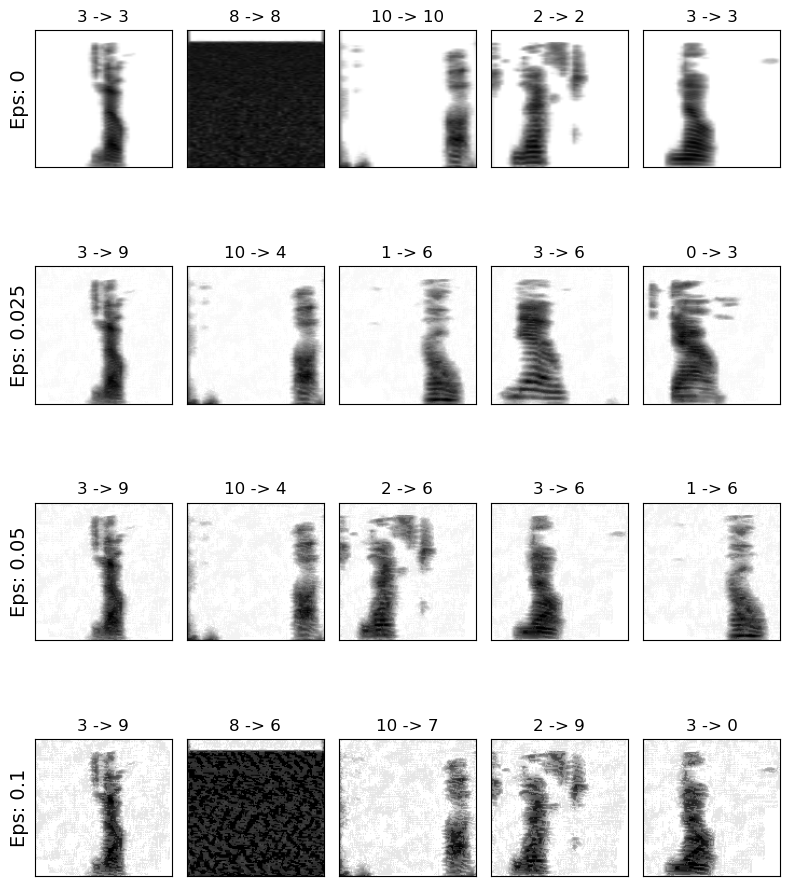

In [41]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()